In [143]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [144]:
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Resizing, Conv2DTranspose, BatchNormalization, LeakyReLU, UpSampling2D, Conv2D, multiply, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [145]:
images = np.load("/content/drive/MyDrive/images.npy")
labels = np.load("/content/drive/MyDrive/labels.npy")

In [146]:
labels

array(['drink', 'drink', 'drink', ..., 'outside', 'outside', 'outside'],
      dtype='<U7')

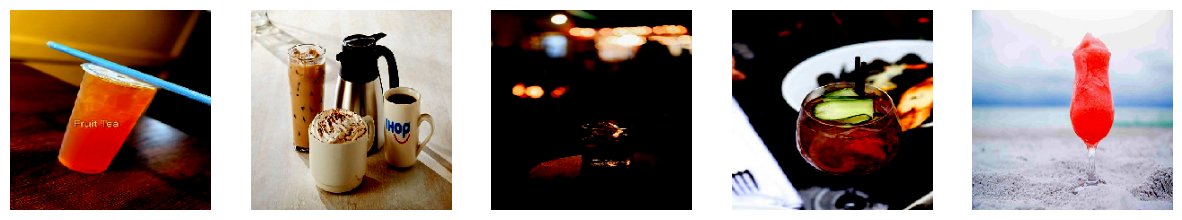

In [ ]:
num_images = 5
fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
for i in range(num_images):
    axs[i].imshow(images[i, :, :, :]) 
    axs[i].axis('off')
plt.show()

In [148]:
labels_unique = np.unique(labels)
print(f"Unique labels: {labels_unique}")

Unique labels: ['drink' 'food' 'inside' 'menu' 'outside']


In [149]:
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Images shape: (8390, 224, 224, 3)
Labels shape: (8390,)


In [150]:
print(f"Image pixel value range: {images.min()} to {images.max()}")
print(f"Labels shape after one-hot encoding: {labels.shape}")

Image pixel value range: -1.0 to 1.0
Labels shape after one-hot encoding: (8390,)


Total images for class 'menu': (1678, 224, 224, 3)


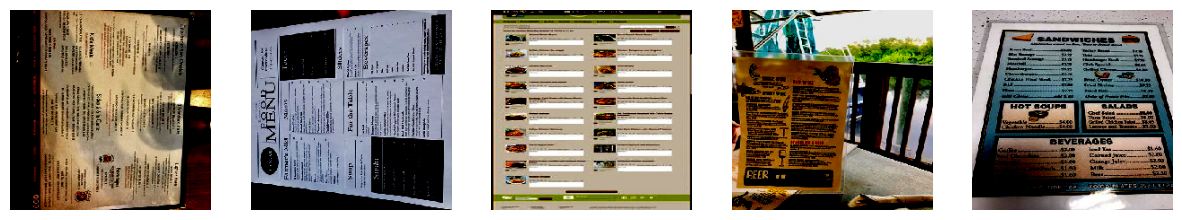

In [ ]:
selected_class = 'menu'
class_indices = np.where(labels == selected_class)[0]
class_images = images[class_indices]

print(f"Total images for class '{selected_class}': {class_images.shape}")

num_images = 5
fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
for i in range(num_images):
    axs[i].imshow(class_images[i, :, :, :]) 
    axs[i].axis('off')
plt.show()

In [152]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [ ]:
num_classes = len(label_encoder.classes_)
one_hot_labels = to_categorical(encoded_labels, num_classes)

print(f"Encoded labels: {encoded_labels[:5]}")
print(f"Labels shape after one-hot encoding: {one_hot_labels.shape}")

Encoded labels: [0 0 0 0 0]
Labels shape after one-hot encoding: (8390, 5)


In [154]:
target_shape = (64, 64, 3)
images = np.array([tf.image.resize(image, target_shape[:2]).numpy() for image in images])

In [155]:
train_images, test_images, train_labels, test_labels = train_test_split(
    images, one_hot_labels, test_size=0.2, random_state=42
)

In [156]:
print(f"Training set: {train_images.shape}, {train_labels.shape}")
print(f"Evaluation set: {test_images.shape}, {test_labels.shape}")

Training set: (6712, 64, 64, 3), (6712, 5)
Evaluation set: (1678, 64, 64, 3), (1678, 5)


In [157]:
#parameters
latent_dim = 200
img_shape = (64, 64, 3)

In [ ]:
def build_generator(latent_dim, num_classes, img_shape):
  
    noise_input = Input(shape=(latent_dim,), name="noise_input")
    label_input = Input(shape=(num_classes,), name="label_input")

    label_dense = Dense(latent_dim, name="label_dense")(label_input) 
    label_dense = BatchNormalization(momentum=0.8, name="label_batchnorm")(label_dense)
    label_dense = LeakyReLU(alpha=0.2, name="label_activation")(label_dense)

    merged_input = Concatenate(name="merged_input")([noise_input, label_dense])

    x = Dense(128 * 8 * 8, activation="relu", name="dense_projection")(merged_input)
    x = Reshape((8, 8, 128), name="reshape_layer")(x)

    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", name="conv2dtranspose_1")(x)  
    x = BatchNormalization(momentum=0.8, name="batchnorm_1")(x)
    x = LeakyReLU(alpha=0.2, name="activation_1")(x)

    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", name="conv2dtranspose_2")(x)  
    x = BatchNormalization(momentum=0.8, name="batchnorm_2")(x)
    x = LeakyReLU(alpha=0.2, name="activation_2")(x)

    x = Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", name="conv2dtranspose_3")(x) 
    x = BatchNormalization(momentum=0.8, name="batchnorm_3")(x)
    x = LeakyReLU(alpha=0.2, name="activation_3")(x)

    img_output = Conv2D(img_shape[2], kernel_size=3, padding="same", activation='tanh', name="img_output")(x)

    return Model([noise_input, label_input], img_output, name="Generator")

In [ ]:
def build_discriminator(img_shape, num_classes):

    img_input = Input(shape=(None, None, img_shape[2]), name="img_input") 

    resized_img = Resizing(64, 64, name="resize_layer")(img_input)

    label_input = Input(shape=(num_classes,), name="label_input")
    label_embedding = Dense(np.prod(img_shape), name="label_dense")(label_input)  
    label_embedding = Reshape(img_shape, name="label_reshape")(label_embedding)

    merged_input = Concatenate(axis=-1, name="merged_input")([resized_img, label_embedding])

    x = Conv2D(64, kernel_size=3, strides=2, padding="same", name="conv2d_1")(merged_input)
    x = BatchNormalization(momentum=0.8, name="batchnorm_1")(x)
    x = LeakyReLU(alpha=0.2, name="activation_1")(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding="same", name="conv2d_2")(x)
    x = BatchNormalization(momentum=0.8, name="batchnorm_2")(x)
    x = LeakyReLU(alpha=0.2, name="activation_2")(x)

    x = Conv2D(256, kernel_size=3, strides=2, padding="same", name="conv2d_3")(x)
    x = BatchNormalization(momentum=0.8, name="batchnorm_3")(x)
    x = LeakyReLU(alpha=0.2, name="activation_3")(x)

    x = Flatten(name="flatten")(x)
    validity = Dense(1, activation='sigmoid', name="validity_output")(x)

    return Model([img_input, label_input], validity, name="Discriminator")


In [160]:
 def save_generated_images(generator, epoch, save_path="generated_images"):
    os.makedirs(save_path, exist_ok=True)
    noise = np.random.normal(0, 1, (num_classes, latent_dim))
    sampled_labels = np.eye(num_classes)
    gen_imgs = generator.predict([noise, sampled_labels])
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]

    for i in range(num_classes):
        plt.imsave(f"{save_path}/epoch_{epoch}_class_{i}.png", gen_imgs[i])


In [161]:
generator = build_generator(latent_dim, num_classes, img_shape)
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 label_input (InputLayer)    [(None, 5)]                  0         []                            
                                                                                                  
 label_dense (Dense)         (None, 200)                  1200      ['label_input[0][0]']         
                                                                                                  
 label_batchnorm (BatchNorm  (None, 200)                  800       ['label_dense[0][0]']         
 alization)                                                                                       
                                                                                                  
 noise_input (InputLayer)    [(None, 200)]                0         []                    

In [162]:
discriminator = build_discriminator(img_shape, num_classes)
discriminator.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 label_input (InputLayer)    [(None, 5)]                  0         []                            
                                                                                                  
 img_input (InputLayer)      [(None, None, None, 3)]      0         []                            
                                                                                                  
 label_dense (Dense)         (None, 12288)                73728     ['label_input[0][0]']         
                                                                                                  
 resize_layer (Resizing)     (None, 64, 64, 3)            0         ['img_input[0][0]']           
                                                                                      

In [163]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

In [164]:
discriminator.trainable = False

In [ ]:
# Generator inputs
noise_input = Input(shape=(latent_dim,), name="noise_input")  
label_input = Input(shape=(num_classes,), name="label_input") 
validity = discriminator([generated_img, label_input])

In [166]:
cgan = Model([noise_input, label_input], validity, name="cGAN")
cgan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [167]:
# Training parameters
epochs = 5000
batch_size = 8
save_interval = 5000

In [ ]:
valid = np.ones((batch_size, 1)) 
fake = np.zeros((batch_size, 1)) 

In [169]:
discriminator_losses = []
generator_losses = []
discriminator_accuracies = []

1/1 [==============================] - 0s 183ms/step
Epoch 0/5000
[D loss: 1.6570, acc.: 6.25%] [G loss: 0.6787]
1/1 [==============================] - 0s 31ms/step


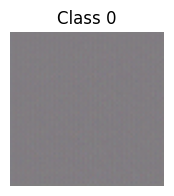

1/1 [==============================] - 0s 31ms/step


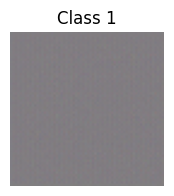

1/1 [==============================] - 0s 32ms/step


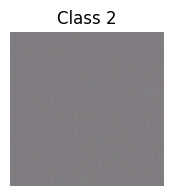

1/1 [==============================] - 0s 32ms/step


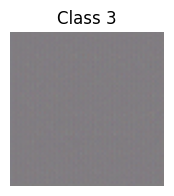

1/1 [==============================] - 0s 31ms/step


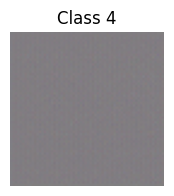

Displayed images for all labels.
1/1 [==============================] - 0s 44ms/step
Epoch 100/5000
[D loss: 0.0013, acc.: 100.00%] [G loss: 0.0009]
1/1 [==============================] - 0s 41ms/step
Epoch 200/5000
[D loss: 0.0003, acc.: 100.00%] [G loss: 0.0001]
1/1 [==============================] - 0s 40ms/step
Epoch 300/5000
[D loss: 0.0003, acc.: 100.00%] [G loss: 0.0001]
1/1 [==============================] - 0s 36ms/step
Epoch 400/5000
[D loss: 0.0001, acc.: 100.00%] [G loss: 0.0002]
1/1 [==============================] - 0s 34ms/step
Epoch 500/5000
[D loss: 0.0002, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 33ms/step
Epoch 600/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 35ms/step
Epoch 700/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 34ms/step
Epoch 800/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 

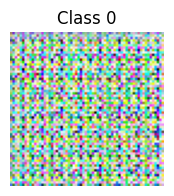

1/1 [==============================] - 0s 31ms/step


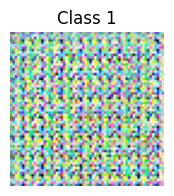

1/1 [==============================] - 0s 29ms/step


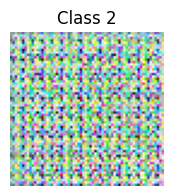

1/1 [==============================] - 0s 30ms/step


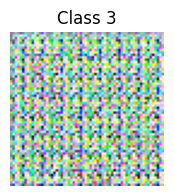

1/1 [==============================] - 0s 29ms/step


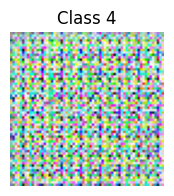

Displayed images for all labels.
1/1 [==============================] - 0s 42ms/step
Epoch 1100/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 40ms/step
Epoch 1200/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 45ms/step
Epoch 1300/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 45ms/step
Epoch 1400/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 41ms/step
Epoch 1500/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 36ms/step
Epoch 1600/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 34ms/step
Epoch 1700/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 40ms/step
Epoch 1800/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==========================

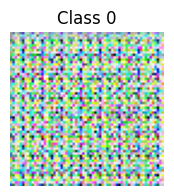

1/1 [==============================] - 0s 30ms/step


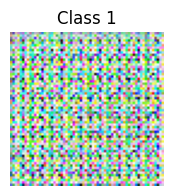

1/1 [==============================] - 0s 29ms/step


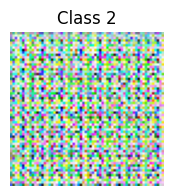

1/1 [==============================] - 0s 29ms/step


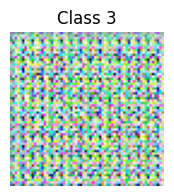

1/1 [==============================] - 0s 29ms/step


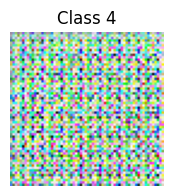

Displayed images for all labels.
1/1 [==============================] - 0s 32ms/step
Epoch 2100/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 44ms/step
Epoch 2200/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 52ms/step
Epoch 2300/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 41ms/step
Epoch 2400/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 37ms/step
Epoch 2500/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 34ms/step
Epoch 2600/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 41ms/step
Epoch 2700/5000
[D loss: 0.0001, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 42ms/step
Epoch 2800/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==========================

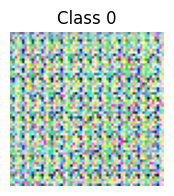

1/1 [==============================] - 0s 31ms/step


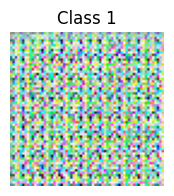

1/1 [==============================] - 0s 34ms/step


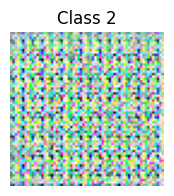

1/1 [==============================] - 0s 32ms/step


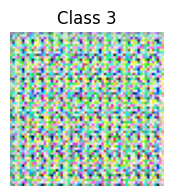

1/1 [==============================] - 0s 34ms/step


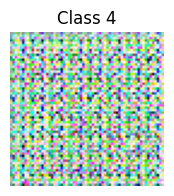

Displayed images for all labels.
1/1 [==============================] - 0s 34ms/step
Epoch 3100/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 41ms/step
Epoch 3200/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 45ms/step
Epoch 3300/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 42ms/step
Epoch 3400/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 40ms/step
Epoch 3500/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 44ms/step
Epoch 3600/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 33ms/step
Epoch 3700/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==============================] - 0s 38ms/step
Epoch 3800/5000
[D loss: 0.0000, acc.: 100.00%] [G loss: 0.0000]
1/1 [==========================

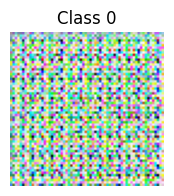

1/1 [==============================] - 0s 29ms/step


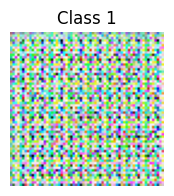

1/1 [==============================] - 0s 30ms/step


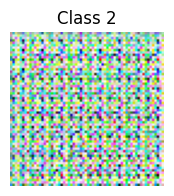

1/1 [==============================] - 0s 29ms/step


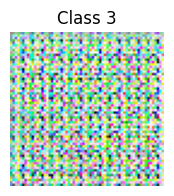

1/1 [==============================] - 0s 29ms/step


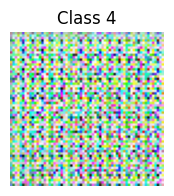

Displayed images for all labels.
1/1 [==============================] - ETA: 0s

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

def display_images_per_label(generator, latent_dim, num_classes, epoch=None):

    # Generate one image per class
    for label in range(num_classes):
        noise = np.random.normal(0, 1, (1, latent_dim)) 
        one_hot_label = to_categorical([label], num_classes) 

        gen_img = generator.predict([noise, one_hot_label])[0]

        gen_img = (gen_img + 1) / 2.0  

        plt.figure(figsize=(2, 2))
        plt.imshow(gen_img)
        plt.axis('off')
        label_name = f"label_{label}" if epoch is None else f"label_{label}_epoch_{epoch}"
        plt.title(f"Class {label}")
        plt.show() 

    print(f"Displayed images for all labels.")

for epoch in range(epochs):

    #  Train Discriminator
    idx = np.random.randint(0, train_images.shape[0], batch_size)
    real_imgs, real_labels = train_images[idx], train_labels[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    sampled_labels = np.random.randint(0, num_classes, size=batch_size)
    one_hot_labels = to_categorical(sampled_labels, num_classes)
    gen_imgs = generator.predict([noise, one_hot_labels])

    d_loss_real = discriminator.train_on_batch([real_imgs, real_labels], valid)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, one_hot_labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    #  Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    sampled_labels = np.random.randint(0, num_classes, size=batch_size)
    one_hot_labels = to_categorical(sampled_labels, num_classes)

    g_loss = cgan.train_on_batch([noise, one_hot_labels], valid)
    g_loss_scalar = g_loss[0] if isinstance(g_loss, (list, tuple)) else g_loss

    discriminator_losses.append(d_loss[0])  
    generator_losses.append(g_loss_scalar)
    discriminator_accuracies.append(d_loss[1]) 

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs}")
        print(f"[D loss: {d_loss[0]:.4f}, acc.: {d_loss[1] * 100:.2f}%] [G loss: {generator_losses[-1]:.4f}]")

    if epoch % 1000 == 0:
        display_images_per_label(generator, latent_dim, num_classes, epoch=epoch)

display_images_per_label(generator, latent_dim, num_classes)

generator.save('generator_model.h5')
